# Division Sigma 2020 Ignition Hacks
Authors: Rohit Ganti, Baladithya Balamurugan

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import re
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import time
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from tensorflow.keras.layers import Input, Dense # only use these layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import * # you can use any optimizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
!rm contestant_judgment.csv 
!wget https://raw.githubusercontent.com/Codeseys/IgnitionHacks2020DivSigma/master/contestant_judgment.csv 
!rm training_data.csv 
!wget https://raw.githubusercontent.com/Codeseys/IgnitionHacks2020DivSigma/master/training_data.csv

--2020-08-31 12:19:57--  https://raw.githubusercontent.com/Codeseys/IgnitionHacks2020DivSigma/master/contestant_judgment.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)...[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codeseys/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/codeseys/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/codeseys/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/codeseys/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
151.101.0.133, 151.101.192.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response...200 OK
Length: 56472148 (54M) [

In [6]:
df_train = pd.read_csv('training_data.csv')
df_train.head()

,ID,User,Text,Sentiment
0,864192,Carly_FTS,I *heart* filling up @dennisschaub desk 1 it...,1
1,523691,Open_Sourcing,"#SocioMat - people create prettier, younger an...",1
2,584154,xxcharlx,no way i dont want the tour to end,0
3,1527961,andreapuddu,@HemalRadia Hi Amazing Brother! Sending Limitl...,1
4,28609,umbec,@flockmaster they are chocolate,1


In [7]:
stopwordslist =  set(stopwords.words('english'))
lemmatty = WordNetLemmatizer()
wordnetmap = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def removestopwords(text):    
    return " ".join([word for word in str(text).split() if word not in stopwordslist])
def lemmy(text):
    pos_text = nltk.pos_tag(str(text).split())
    return " ".join([lemmatty.lemmatize(word,wordnetmap.get(pos[0],wordnet.NOUN))for word, pos in pos_text])    

def clean_text(text):
    text = re.sub(r'@[A-Za-z0-9]+','',text)
    text = re.sub(r'#','',text)
    
    text = re.sub(r'RT[\s]+','',text)
    text = re.sub(r'https?:\/\/\S+','',text)
    
    text = lemmy(text)
    text = text.lower()
    text = re.sub(r'[^\w\s]','', text)
    text = removestopwords(text)
    
    return text

# df_train['Text']=df_train['Text'].apply(clean_text)
# df_train.head()

In [8]:
TextBlob(df_train['Text'][1]).words

WordList(['SocioMat', 'people', 'create', 'prettier', 'younger', 'and', 'better', 'looking', 'avatars', 'of', 'themselves'])

In [11]:
def vectorizer(data):

  start = time.time()

  tfidf = TfidfVectorizer(analyzer=clean_text,max_features=650)
  tfidfvect = tfidf.fit_transform(data)

  end = time.time()
  hours, rem = divmod(end-start, 3600)
  minutes, seconds = divmod(rem, 60)
  print("--- {:0>2}:{:0>2}:{:05.2f} ---".format(int(hours),int(minutes),seconds))

  print(tfidfvect.shape)
  return pd.DataFrame(tfidfvect.toarray(),columns=tfidf.get_feature_names())

x_tfidf=vectorizer(df_train['Text'])
# x_test_tfidf=vectorizer(x_test)

--- 00:10:31.64 ---
(1000000, 650)


In [12]:

x_tfidf['Length']=df_train['Text'].apply(lambda row: len(row))
x_tfidf.shape

(1000000, 651)

In [13]:
input_layer = Input(shape=(651))
x=Dense(units=200,activation='tanh')(input_layer)
x=Dense(units=200,activation='tanh')(x)
x=Dense(units=2,activation='softmax')(x)
model = Model(input_layer,(x))

In [14]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 651)]             0         
_________________________________________________________________
dense (Dense)                (None, 200)               130400    
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 402       
Total params: 171,002
Trainable params: 171,002
Non-trainable params: 0
_________________________________________________________________


In [15]:
optimizer = RMSprop(learning_rate=0.001)
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
hist = model.fit(x_tfidf, df_train['Sentiment'], epochs=20, validation_split=0.2)

In [12]:
def plot_losses(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()
def plot_accuracies(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()

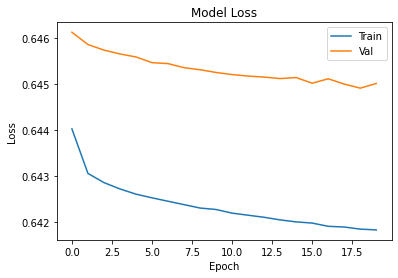

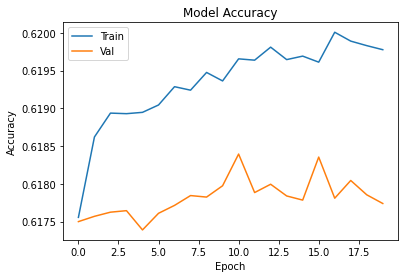

In [13]:
plot_losses(hist)
plot_accuracies(hist)

In [14]:
!mkdir -p models
tf.keras.models.save_model(model,'models/divsigma',overwrite=True,include_optimizer=True,save_format=None,signatures=None,options=None)
!ls -l models/

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/divsigma/assets
total 4
drwxr-xr-x 4 root root 4096 Aug 24 03:04 divsigma


In [4]:
divsigma = tf.keras.models.load_model('models/divsigma')

In [7]:
judge = pd.read_csv('contestant_judgment.csv')
judge_tfidf=vectorizer(judge['Text'])

--- 00:07:54.82 ---
(599999, 989)


ValueError: ignored

In [9]:
# for i in range(321):
#   title = str(i) +' new'
#   judge_tfidf[title]=0
# judge_tfidf.shape

(599999, 1310)

In [10]:
judge_predict = divsigma.predict(judge_tfidf)

AttributeError: ignored

In [ ]:
ndf = pd.DataFrame(judge_predict, columns=['Sentiment'])
print(ndf.head())

In [18]:
ndf_correct = ndf
ndf_correct['Sentiment'] = ndf_correct['Sentiment'].apply(lambda row: 1 if row>=0.5 else 0)
print(ndf_correct.head())
judgefinal = pd.concat([judge,ndf_correct],axis=1)
judgefinal.head()
judgefinal.to_csv('Sadness_RohitGanti_BaladithyaBalamurugan.csv')

   Sentiment
0   0.367031
1   0.536084
2   0.396976
3   0.498867
4   0.486445
   Sentiment
0          0
1          1
2          0
3          0
4          0


In [ ]:
# cvec= TfidfVectorizer( analyzer='word', stop_words= 'english', max_features=7500, lowercase= True)
# documents= df['Text'].values.astype('U')
# X= cvec.fit_transform(documents).toarray()
# words= cvec.get_feature_names()
# y=df['Sentiment']
# X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, shuffle= True)

# start= timer();

# logreg= LogisticRegression(max_iter=500)
# logreg.fit(X_train, y_train)

# y_pred= logreg.predict(X_test)
# result= classification_report(y_test, y_pred)
# print(result)
# end= timer();


# score= logisticReg.score(X_test, y_test)
# print("Score of our model is: " +str(score))
# print("Time for the model is: " +str(end-start))


In [6]:
# # df_train.to_csv('newcsvtest.csv')
# SEED=114
# x = x_tfidf
# y = df_train['Sentiment']

# x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=SEED)

# print("xTrain:",x_train.shape,"yTrain:",y_train.shape)
# print("xTest:",x_test.shape,"yTest:",y_test.shape)

xTrain: (800000, 1310) yTrain: (800000,)
xTest: (200000, 1310) yTest: (200000,)


In [7]:
# print(x_train.head())
# print(x_test.head())
# print(y_train.head())
# print(y_test.head())

                    0    1         2         3  ...    ｇ    ｗ    ｚ    ｲ    ﾟ
737513  0.402839  0.0  0.0  0.000000  0.000000  ...  0.0  0.0  0.0  0.0  0.0
731241  0.363100  0.0  0.0  0.469871  0.000000  ...  0.0  0.0  0.0  0.0  0.0
192316  0.363773  0.0  0.0  0.000000  0.000000  ...  0.0  0.0  0.0  0.0  0.0
968202  0.565131  0.0  0.0  0.137121  0.146214  ...  0.0  0.0  0.0  0.0  0.0
536041  0.478565  0.0  0.0  0.000000  0.000000  ...  0.0  0.0  0.0  0.0  0.0

[5 rows x 1310 columns]
                    0    1    2    3    4  ...    ｄ    ｇ    ｗ    ｚ    ｲ    ﾟ
147116  0.422194  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0
360159  0.298122  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0
192905  0.346685  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0
757661  0.290373  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0
279194  0.322785  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0

[5 rows x 1310 columns]
737513    0
731241    0
19

In [ ]:
# start = time.time()
# logreg = LogisticRegression(max_iter=500,solver='sag',random_state=SEED,C=1).fit(x_train.astype('float64'),y_train)
# end = time.time()
# hours, rem = divmod(end-start, 3600)
# minutes, seconds = divmod(rem, 60)
# print("--- {:0>2}:{:0>2}:{:05.2f} ---".format(int(hours),int(minutes),seconds))

# y_pred = logreg.predict(x_test)
# result = classification_report(y_test,y_pred)
# print(result)
# score= logisticReg.score(X_test, y_test)
# print("Score of our model is: " +str(score))